In [1]:
%cd ..

import urllib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from einops import repeat
from PIL import Image
from pyro.distributions import ZeroInflatedPoisson
from scipy.special import lambertw
from torch.distributions import Categorical, MixtureSameFamily
from torch.nn.functional import one_hot

from mixture.k_means import KMeans
from utils.dataset import ObjectCooccurrenceCOCODataset

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [117]:
torch.manual_seed(0)

device = "cuda" if not torch.cuda.is_available() else "cpu"

dataset_train = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")
dataloader_train = torch.utils.data.DataLoader(dataset_train, len(dataset_train), True)

dataset_valid = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, 64)

sampler = torch.distributions.Categorical(
    logits=torch.zeros(dataset_train.features.shape[0])
)

k = 4

max_value = dataset_train.features.to_numpy().max()

step_size = 1.0
num_iteration = 300


def create_mixture(params, eps=1e-5):
    return torch.distributions.MixtureSameFamily(
        mixture_distribution=torch.distributions.Categorical(params["prior"]),
        component_distribution=torch.distributions.Independent(
            torch.distributions.Categorical(params["probs"]),
            1,
        ),
    )


def init_parameters(dataset, k):
    sampler = torch.distributions.Categorical(
        logits=torch.zeros(dataset_train.features.shape[0])
    )

    params = torch.nn.ParameterDict()

    prior = torch.zeros(k).softmax(-1)
    probs = dataset_train.features.iloc[sampler.sample([k])].to_numpy()
    probs = torch.from_numpy(probs)
    probs = one_hot(probs, max_value + 1).float()

    params["prior"] = prior
    params["probs"] = probs

    return params


print("Mixture", "Restarts", "Step", "Loss", sep="\t\t")
for k in range(3, 4):
    for i in range(1):
        params = init_parameters(dataset_train, k + 1)

        params = params.to(device)

        loss_old = float("inf")
        for j in range(50):
            loss = 0
            n = 0

            # Stochastic EM
            for inputs in dataloader_train:
                inputs = inputs.to(device)
                inputs_expand = repeat(inputs, "n d -> n 1 d")
                inputs_ohe = one_hot(inputs_expand, max_value + 1)
                mixture = create_mixture(params)

                # 1) E-Step
                log_prior = mixture.mixture_distribution.probs.log()
                log_likelihood = mixture.component_distribution.log_prob(inputs_expand)
                posterior = (log_prior + log_likelihood).softmax(-1)

                # 2) M-Step

                # a) MLE
                posterior_expand = repeat(posterior, "n k -> n k 1 1")
                count = repeat(posterior.sum(0), "k -> k 1 1")

                prior_ = posterior.mean(0)
                probs_ = (posterior_expand * inputs_ohe).sum(0) / count

                # b) Update rule
                prior = params["prior"]
                probs = params["probs"]
                
                prior_.mul_(step_size)
                probs_.mul_(step_size)

                params["prior"].mul_(1-step_size).add_(prior_)
                params["probs"].mul_(1-step_size).add_(probs)

                # 3) Update NLL
                loss += mixture.log_prob(inputs).sum().neg()
                n += inputs.size(0)

            loss = (loss / n).item()

            if abs(loss_old - loss) < 1e-5:
                break
            else:
                loss_old = loss

            print(k + 1, i + 1, j + 1, "{:.4f}".format(loss), sep="\t\t")

Mixture		Restarts		Step		Loss
4		1		1		75.6629
4		1		2		14.2944
4		1		3		13.9581
4		1		4		13.7794
4		1		5		13.6934
4		1		6		13.6489
4		1		7		13.6261
4		1		8		13.6139
4		1		9		13.6066
4		1		10		13.6018
4		1		11		13.5984
4		1		12		13.5960
4		1		13		13.5941
4		1		14		13.5926
4		1		15		13.5913
4		1		16		13.5901
4		1		17		13.5888
4		1		18		13.5875
4		1		19		13.5861
4		1		20		13.5844
4		1		21		13.5825
4		1		22		13.5804
4		1		23		13.5780
4		1		24		13.5756
4		1		25		13.5734
4		1		26		13.5715
4		1		27		13.5699
4		1		28		13.5686
4		1		29		13.5675
4		1		30		13.5668
4		1		31		13.5662
4		1		32		13.5658
4		1		33		13.5655
4		1		34		13.5652
4		1		35		13.5650
4		1		36		13.5649
4		1		37		13.5648
4		1		38		13.5647
4		1		39		13.5646
4		1		40		13.5645
4		1		41		13.5644
4		1		42		13.5644
4		1		43		13.5643
4		1		44		13.5643
4		1		45		13.5643
4		1		46		13.5643
4		1		47		13.5642
4		1		48		13.5642
4		1		49		13.5642
4		1		50		13.5642


In [125]:
torch.full([], 0.5)

tensor(0.5000)

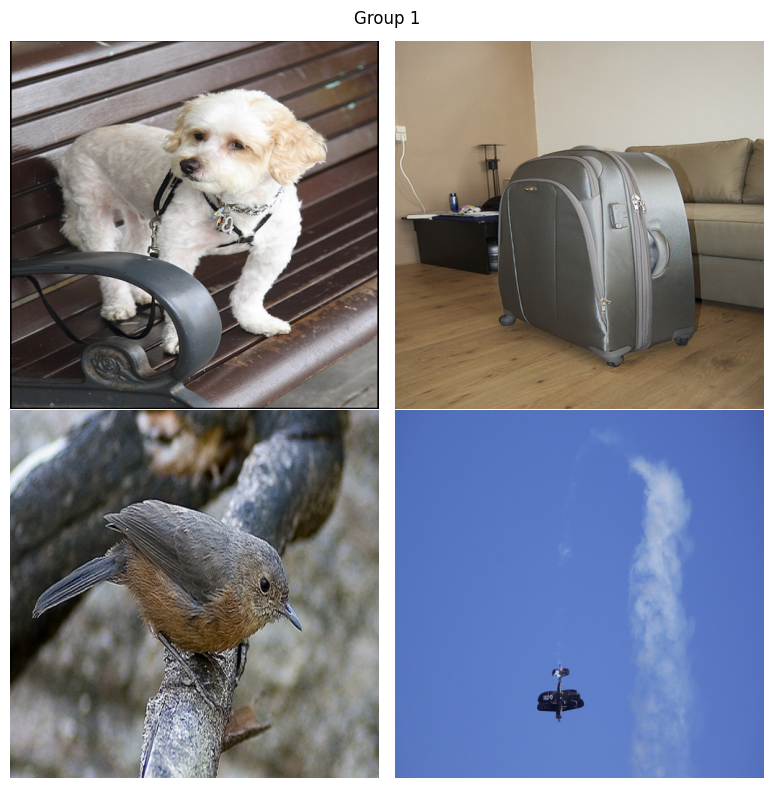

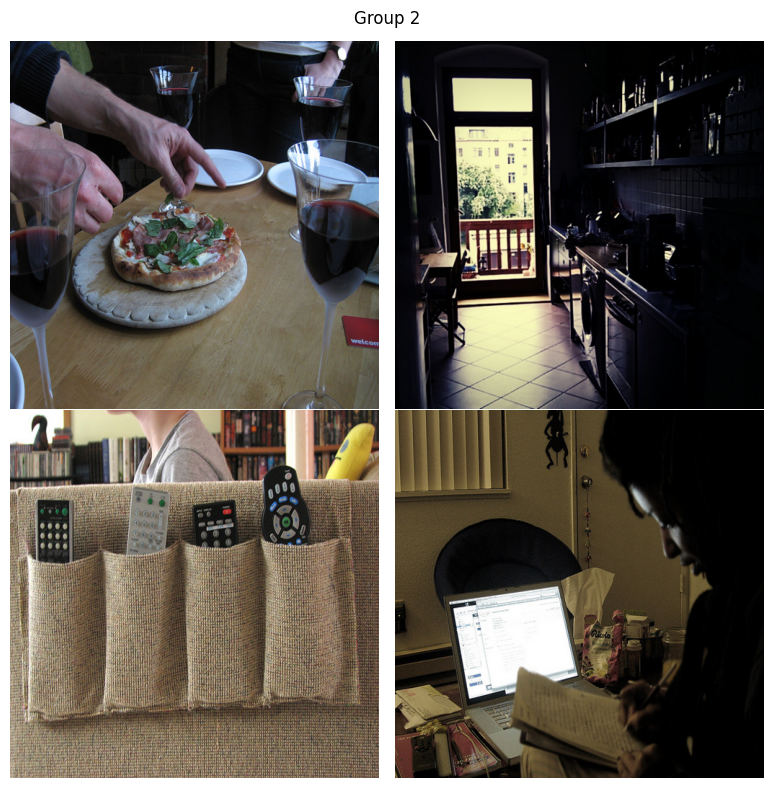

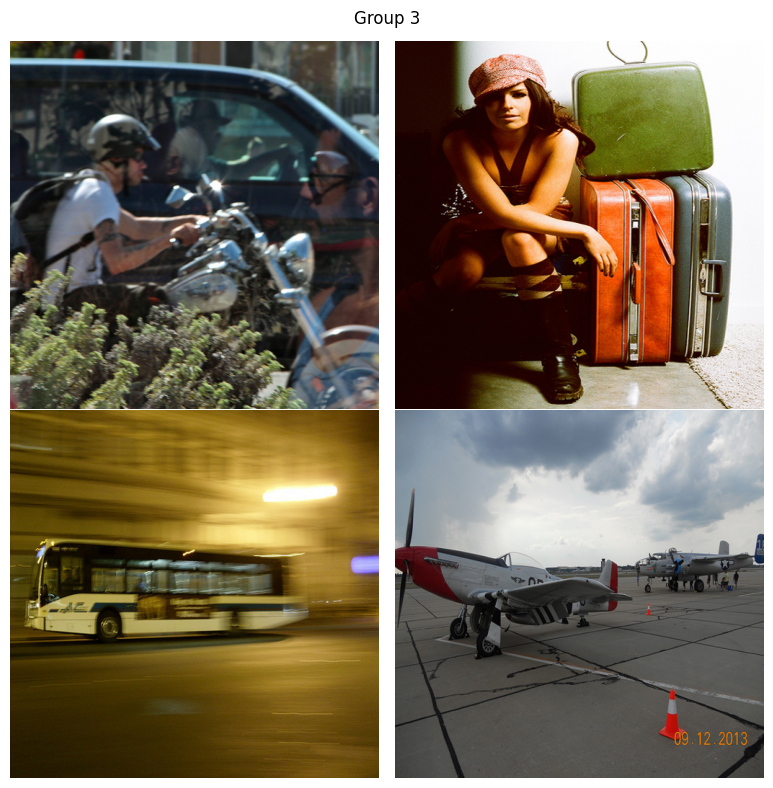

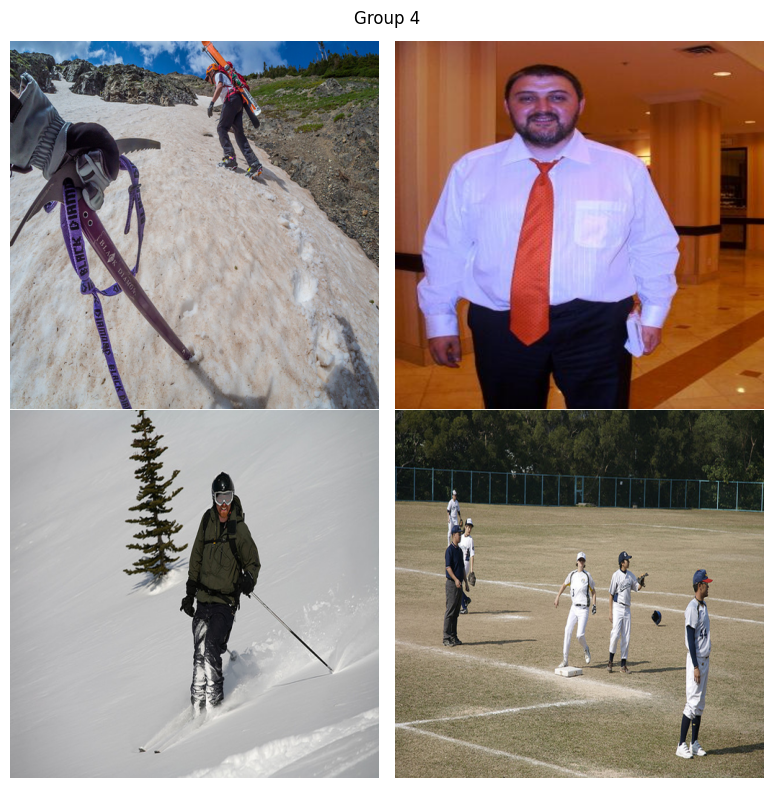

In [118]:
torch.manual_seed(0)

inputs = torch.from_numpy(dataset_valid.features.to_numpy())
inputs_expand = repeat(inputs, "n d -> n 1 d")
inputs_ohe = one_hot(inputs_expand, max_value + 1)

with torch.inference_mode():
    log_prior = mixture.mixture_distribution.probs.log()
    log_likelihood = mixture.component_distribution.log_prob(inputs_expand)
    posterior = (log_prior + log_likelihood).softmax(-1)
    max_aposteriori = posterior.max(-1)

idx = max_aposteriori.indices


for i in range(k + 1):
    ids = torch.where(idx == i)
    sample = dataset_valid.metadata.iloc[ids].sample(4, replace=False, random_state=0)
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(f"Group {i+1}")
    for n, row in enumerate(sample.iloc, 1):
        ax = fig.add_subplot(2, 2, n)
        img = Image.open(urllib.request.urlopen(row.coco_url))
        ax.imshow(img.resize((512, 512)))
        ax.axis("off")
        ax.set_aspect("equal")
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.show()

In [119]:
inputs_ohe = one_hot(torch.from_numpy(dataset_train.features.to_numpy()), max_value + 1)
idp = inputs_ohe.float().mean(0)

with torch.inference_mode():
    idp_expected_value = (idp * torch.arange(max_value + 1)).sum(-1)

In [120]:
idp_dist = torch.distributions.Independent(torch.distributions.Categorical(idp), 1)
idp_dist.log_prob(inputs).mean()

tensor(-14.9436)

In [123]:
mixture.log_prob(inputs).mean()

tensor(-13.7246, grad_fn=<MeanBackward0>)

In [121]:
with torch.inference_mode():
    expected_value = (params["probs"] * torch.arange(max_value + 1)).sum(-1)

plt.figure(figsize=(15, 15), dpi=512)
for i in range(k + 1):
    plt.bar(
        dataset_valid.features.columns,
        expected_value[i],
        label=f"Mixture {i+1}",
        color=plt.cm.tab20.colors[i % 20],
    )

plt.xticks(rotation="vertical")
plt.xlabel("Features")
plt.ylabel("Expected Value")

plt.legend()
plt.autoscale(enable=True, axis="both", tight=True)

plt.tight_layout()